# Abstract:
An analysis on Disney World parks in order to determine the shortest and longest wait times in correlation to day of week, temperature, seasons, and other rides within the park. Due to an abundance of data available on this topic, we narrow our focus down to Disney World’s Magic Kingdom Park and its most popular ride, Splash Mountain during Disney’s peak season in July.

Furthering our finds, we dive into machine learning to answer the question of:
Can we determine what the average wait time will be for Splash Mountain on a certain day in July 2018?


# Methods:
In the data cleaning step we utilized aggregations and reshaping - such as merging multiple data sets - for use. After tossing out missing data points and handling outliers as well as scaling our features, we were able to construct an all-encompassing dataset for exploratory analysis.

Within our exploratory data analysis, we created various pivots and aggregations in relation to each correlated variable, of which we found 41 strongly correlated values for the posted wait time. Focusing in on the crucial correlated values, we produced time series plots in relation to wait times on dates and wait times in July specifically, heatmaps in relation to datetimes, week of year and temperatures, histograms in relation to wait times by day of week/month and average park attendance, and a distribution plot in relation to frequency of each wait time. 

Utilized machine learning techniques such as Random Forests, Linear Regression, Lasso and Ridge Regression to determine which model would be the most successful at predicting the average wait times for Splash Mountain in July 2018.


# Exploring Disney Land Wait Time Data Set
## Loading libraries and reading in data

In [1]:
import pandas as pd ## call pandas functions using "pd"
import numpy as np  ## call numpy functions using "np"

import sklearn.decomposition as skld

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

#import meta data
meta = pd.read_csv("disney.csv")

#import magic kingdom rides (wait times)
splash = pd.read_csv("splash_mountain.csv")
seven_dwarfs = pd.read_csv("7_dwarfs_train.csv")
pirates = pd.read_csv('pirates_of_caribbean.csv')

The two main datasets we utilized were the meta dataset and the splash dataset. The meta dataset included 190 variables and observations per day, since 2012. These variables described various factors, such as season, temperature, percentage of schools in session, park hours and parades (for every Disney World park).

The splash dataset had the wait times for the Splash Mountain ride from 2012 to the present. It included posted wait time, SPOSTMIN, and actual wait time, SACTMIN. The difference between these two were that the posted wait times were the wait times that were posted at the entrance of the ride, and were times we assumed were inferred through past wait times and data. 
The actual wait time is found by Disney World ride employees handing a card to a person, who lines up for the duration of the ride, and gives the card back to the ride employee before boarding the ride so that they can gauge an actual wait time and therefore change their posted wait time accordingly. 


### Viewing the meta and Splash Dataset

In [2]:
print(meta.shape) #190 columns, 2674 rows of observations
#First five rows of meta, five columns, 
# start date 2012
meta.iloc[0:5, 0:10]

(2674, 190)


,DATE,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM
0,01/01/2012,NaN,1,0,1,1,2012,CHRISTMAS PEAK,0,5
1,01/02/2012,NaN,2,1,1,1,2012,CHRISTMAS,2,5
2,01/03/2012,NaN,3,2,1,1,2012,CHRISTMAS,3,0
3,01/04/2012,NaN,4,3,1,1,2012,CHRISTMAS,4,0
4,01/05/2012,NaN,5,4,1,1,2012,CHRISTMAS,5,0


We drop observations that do not have a wait time, which is coded as -999, indicating that the ride was possibly closed or not operating during that time period.

In [3]:
# Drop rows where wait time is not available (-999)
pirates = pirates[pirates.SPOSTMIN > 0]
seven_dwarfs = seven_dwarfs[seven_dwarfs.SPOSTMIN > 0]
splash = splash[(splash.SPOSTMIN > 0) | (splash.SACTMIN > 0)]

splash.head() #has posted minutes for each ride

,date,datetime,SPOSTMIN,SACTMIN
0,01/01/2012,2012-01-01 10:31:00,30.0,NaN
1,01/01/2012,2012-01-01 10:40:00,30.0,NaN
2,01/01/2012,2012-01-01 10:32:00,NaN,13.0
3,01/01/2012,2012-01-01 12:02:00,30.0,NaN
4,01/01/2012,2012-01-01 12:04:00,NaN,23.0


In [4]:
na_post = splash['SPOSTMIN'].isna().sum()
na_actual = splash['SACTMIN'].isna().sum()



print ("There are", na_post ,"missing values in SPOSTMIN")
print ("There are", na_actual ,"missing values in SACTMIN")

There are 5445 missing values in SPOSTMIN
There are 247122 missing values in SACTMIN


As we can see here, there is a very big discrepancy between the amount of observations for posted wait times and actual wait times. Therefore, for our analysis we chose to only work with the posted wait times. (To be explained with histograms later)

## Merging datasets together to include wait times for Splash Mountain

We continued our analysis of wait times by calculating an average wait time by day for Splash Mountain and merging this back into the meta dataset to include average daily wait times.

In [5]:
#Merging each ride with meta_data, using date as key
meta_splash = pd.merge(splash, meta, left_on="date", right_on="DATE").drop('DATE', axis = 1)

In [6]:
#change NAs to 0 values
meta_splash = meta_splash.fillna(0)
#format date in a way that can be worked with
meta_splash['date'] = pd.to_datetime(meta_splash['date'])
meta_splash.head()

,date,datetime,SPOSTMIN,SACTMIN,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,2012-01-01,2012-01-01 10:31:00,30.0,0.0,0,1,0,1,1,2012,...,1,1,15:45,0.0,Mickey's Jingle Jungle Parade,0.0,0,0,0,0
1,2012-01-01,2012-01-01 10:40:00,30.0,0.0,0,1,0,1,1,2012,...,1,1,15:45,0.0,Mickey's Jingle Jungle Parade,0.0,0,0,0,0
2,2012-01-01,2012-01-01 10:32:00,0.0,13.0,0,1,0,1,1,2012,...,1,1,15:45,0.0,Mickey's Jingle Jungle Parade,0.0,0,0,0,0
3,2012-01-01,2012-01-01 12:02:00,30.0,0.0,0,1,0,1,1,2012,...,1,1,15:45,0.0,Mickey's Jingle Jungle Parade,0.0,0,0,0,0
4,2012-01-01,2012-01-01 12:04:00,0.0,23.0,0,1,0,1,1,2012,...,1,1,15:45,0.0,Mickey's Jingle Jungle Parade,0.0,0,0,0,0


In [7]:
#Getting average wait times per day:

#find all posted/actual wait times by day in meta_splash
sum_by_day = meta_splash.groupby('date')['SPOSTMIN'].mean()
#reset index to create dataframe columns
sum_by_day = sum_by_day.reset_index()
#sum_by_day = pd.DataFrame(sum_by_day,columns=['date','SPOSTMIN'])

sum_by_day.head()

,date,SPOSTMIN
0,2012-01-01,31.923077
1,2012-01-02,43.750000
2,2012-01-03,5.000000
3,2012-01-04,15.000000
4,2012-01-05,33.437500


In [8]:
# Finding Mean of SACTMIN per day

# Making dataframe with only SACTMIN
sactmin_df = meta_splash[meta_splash['SACTMIN'] > 0]  

#find all actual wait times by day in meta_splash
sact_by_day = sactmin_df.groupby('date')['SACTMIN'].mean()
#reset index to create dataframe columns
sact_by_day = sact_by_day.reset_index()
#sum_by_day = pd.DataFrame(sum_by_day,columns=['date','SPOSTMIN'])

sact_by_day.head()

,date,SACTMIN
0,2012-01-01,18.000000
1,2012-01-04,20.000000
2,2012-01-05,6.666667
3,2012-01-06,4.000000
4,2012-01-07,11.000000


In [9]:
#Merging these wait times back into meta dataset and fill 0 for NA
#For splash 
meta['DATE'] = pd.to_datetime(meta['DATE'])
meta_splash2 = pd.merge(sum_by_day, meta, left_on="date", right_on="DATE").drop('DATE', axis = 1)

# change month and day to names of month and day ie: 1 to Sunday, 1 to January
meta_splash2['DAY'] = meta_splash2['date'].dt.weekday_name
meta_splash2['MONTH'] = meta_splash2['date'].dt.month_name()
meta_splash2 = meta_splash2.fillna(0)
meta_splash2.head(5)


,date,SPOSTMIN,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,...,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN,DAY,MONTH
0,2012-01-01,31.923077,0,1,0,1,1,2012,CHRISTMAS PEAK,0,...,15:45,0.0,Mickey's Jingle Jungle Parade,0.0,0,0,0,0,Sunday,January
1,2012-01-02,43.750000,0,2,1,1,1,2012,CHRISTMAS,2,...,15:45,0.0,Mickey's Jingle Jungle Parade,0.0,0,0,0,0,Monday,January
2,2012-01-03,5.000000,0,3,2,1,1,2012,CHRISTMAS,3,...,15:45,0.0,Mickey's Jammin' Jungle Parade,0.0,0,0,0,0,Tuesday,January
3,2012-01-04,15.000000,0,4,3,1,1,2012,CHRISTMAS,4,...,15:45,0.0,Mickey's Jammin' Jungle Parade,0.0,0,0,0,0,Wednesday,January
4,2012-01-05,33.437500,0,5,4,1,1,2012,CHRISTMAS,5,...,15:45,0.0,Mickey's Jammin' Jungle Parade,0.0,0,0,0,0,Thursday,January


In [55]:
## Metasplash comparing Actual Wait Times vs Posted Wait Times
meta_splash3 = pd.merge(sact_by_day, meta_splash2, left_on="date", right_on="date")
meta_splash3.head(5)

,date,SACTMIN,SPOSTMIN,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,...,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN,DAY,MONTH
0,2012-01-01,18.000000,31.923077,0,1,0,1,1,2012,CHRISTMAS PEAK,...,15:45,0.0,Mickey's Jingle Jungle Parade,0.0,0,0,0,0,Sunday,January
1,2012-01-04,20.000000,15.000000,0,4,3,1,1,2012,CHRISTMAS,...,15:45,0.0,Mickey's Jammin' Jungle Parade,0.0,0,0,0,0,Wednesday,January
2,2012-01-05,6.666667,33.437500,0,5,4,1,1,2012,CHRISTMAS,...,15:45,0.0,Mickey's Jammin' Jungle Parade,0.0,0,0,0,0,Thursday,January
3,2012-01-06,4.000000,33.235294,0,6,5,1,1,2012,CHRISTMAS,...,15:45,0.0,Mickey's Jammin' Jungle Parade,0.0,0,0,0,0,Friday,January
4,2012-01-07,11.000000,22.777778,0,7,6,1,1,2012,CHRISTMAS,...,15:45,0.0,Mickey's Jammin' Jungle Parade,0.0,0,0,0,0,Saturday,January


Meta_splash3 consist of SACTMIN and SPOSTMIN and deleted rows with no values for SACTMIN

# Actual Wait Time vs Posted Wait Times

We can see that there are a lot of missing values for actual posted wait times in comparison to wait times that are posted by Disney World. Actual posted wait times correspond to wait times that are reported by people in line.

### Histogram of SPOSTMIN

count    2383.000000
mean       38.199461
std        18.843322
min         0.000000
25%        24.103381
50%        36.789474
75%        50.330601
max       135.000000
Name: SPOSTMIN, dtype: float64


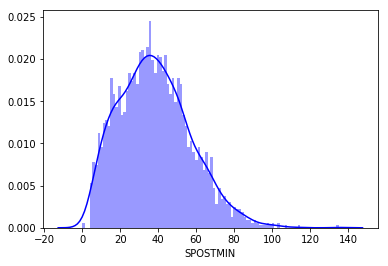

In [64]:
print(meta_splash2['SPOSTMIN'].describe())
sns.distplot(meta_splash2['SPOSTMIN'], color='b', bins=100, hist_kws={'alpha': 0.4});

2383 rows for SPOSTMIN when we average out wait time per day

### Histogram of SACTMIN

count    1914.000000
mean       20.190503
std        14.735284
min         1.000000
25%        10.000000
50%        17.000000
75%        27.000000
max       120.000000
Name: SACTMIN, dtype: float64


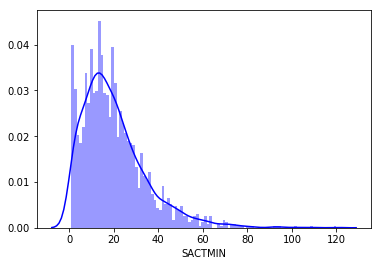

In [63]:
# Printing Wait Times

print(meta_splash3['SACTMIN'].describe())
sns.distplot(meta_splash3['SACTMIN'], color='b', bins=100, hist_kws={'alpha': 0.4});

1914 rows for actual posted wait times when we average out wait time per day

For the purpose of this analysis we will be removing SACTMIN, due to the large number of NA values in the dataset.

# Widget for exploring dataset (SPOSTMIN)

Slide the widget to the right to find days where SPOSTMIN is greater than x

In [66]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


In [67]:
@interact

def show_articles_more_than(column=['SPOSTMIN'], x=(0,140,1)):
    return meta_splash2.loc[meta_splash2['SPOSTMIN']> x ]

interactive(children=(Dropdown(description='column', options=('SPOSTMIN',), value='SPOSTMIN'), IntSlider(value…

### Correlation between SPOSTMIN & Predictors

In [58]:
## Running same code on all of metasplash_2
meta_splash2_corr = meta_splash2.corr()['SPOSTMIN'][:-2]
golden_features_list_2 = meta_splash2_corr[abs(meta_splash2_corr) > 0.20].sort_values(ascending=False)
print("There are {} strongly correlated values with SPOSTMIN:\n{}".format(len(golden_features_list_2), golden_features_list_2))

There are 42 strongly correlated values with SPOSTMIN:
SPOSTMIN              1.000000
AKHOURSYEST           0.537605
AKHOURSEMH            0.536654
AKHOURS               0.536218
AKHOURSTOM            0.532989
AKHOURSEMHYEST        0.526201
AKHOURSEMHTOM         0.512454
MKHOURS               0.413699
MKHOURSEMH            0.394753
HSHOURS               0.363924
HSHOURSTOM            0.353352
HSHOURSYEST           0.345104
EP09CAPACITY          0.340263
WDWMAXTEMP            0.324241
YEAR                  0.322491
HSFIREWK              0.319098
CapacityLost_HS       0.280180
CapacityLostWGT_HS    0.277867
WDWMEANTEMP           0.274337
AKEMHETOM             0.270899
HSHOURSEMHYEST        0.269165
AKEMHEVE              0.266888
AKEMHEYEST            0.265029
HSHOURSEMH            0.262105
HSHOURSEMHTOM         0.257859
WEATHER_WDWPRECIP     0.257285
CapacityLost_EP       0.249109
CapacityLostWGT_EP    0.245590
WEATHER_WDWHIGH       0.237458
CapacityLostWGT_MK    0.232808
HS20CAPACITY   

Looking at this correlation chart we see many correlated features with SPOSTMIN!

## Visualizations on correlated features

In [12]:
#aggregate by year
year_splash = meta_splash2.groupby(['YEAR'])['SPOSTMIN'].mean()
year_splash = year_splash.reset_index()
year_splash.head()

,YEAR,SPOSTMIN
0,2012,31.811774
1,2013,33.951358
2,2014,32.900673
3,2015,32.931315
4,2016,36.014788


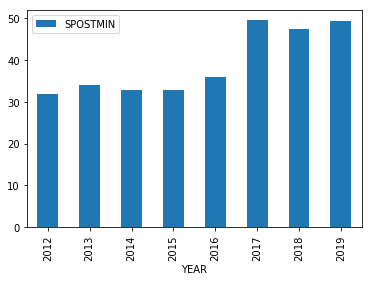

In [71]:
#plot by year
year_splash.plot(x="YEAR", y="SPOSTMIN", kind="bar")

The rising popularity of Disney World is shown in the longer wait times of recent years as shown in the plot above.

#### Wait time by Week 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]), <a list of 54 Text xticklabel objects>)

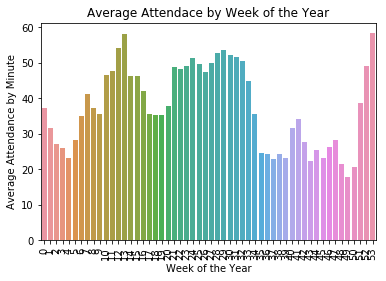

In [16]:
week_avg = meta_splash2.groupby("WEEKOFYEAR")["SPOSTMIN"].mean()
week_avg = week_avg.reset_index()
week_avg = pd.DataFrame(week_avg,columns=['WEEKOFYEAR','SPOSTMIN'])
ax = sns.barplot(x = "WEEKOFYEAR", y = "SPOSTMIN", data = week_avg)
ax.set_title("Average Attendace by Week of the Year")
ax.set(xlabel='Week of the Year', ylabel='Average Attendance by Minute')
plt.xticks(rotation = 90)

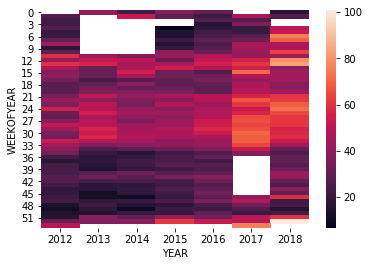

In [17]:
# Grouping by week and year

#aggregate by month
week_splash2 = meta_splash2.groupby(['WEEKOFYEAR', 'YEAR'])['SPOSTMIN'].mean().reset_index()

week_splash2 = week_splash2.pivot("WEEKOFYEAR", "YEAR", "SPOSTMIN").iloc[:,0:7]
ax = sns.heatmap(week_splash2)

#### Temperature vs Wait Time

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

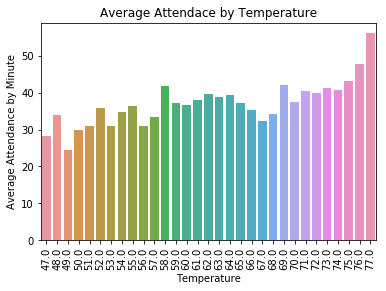

In [18]:
meta_splash2.WDWMINTEMP_mean = meta_splash2.WDWMINTEMP_mean.round()
avg_temp = meta_splash2.groupby("WDWMINTEMP_mean")["SPOSTMIN"].mean()
avg_temp = avg_temp.reset_index()
avg_temp = pd.DataFrame(avg_temp,columns=['WDWMINTEMP_mean','SPOSTMIN'])


ax = sns.barplot(x = "WDWMINTEMP_mean", y = "SPOSTMIN", data = avg_temp)
ax.set_title("Average Attendance by Temperature")
ax.set(xlabel='Temperature', ylabel='Average Attendance by Minute')
plt.xticks(rotation = 90)

Generally, we can see that attendance is higher as the temperature gets hotter.

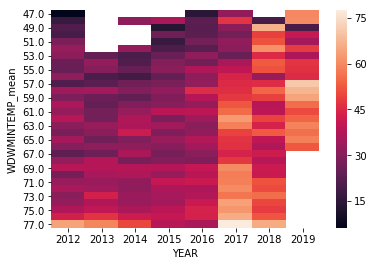

In [19]:
# Grouping by temperature and year

#aggregate by month
temp_splash2 = meta_splash2.groupby(['WDWMINTEMP_mean', 'YEAR'])['SPOSTMIN'].mean().reset_index()

temp_splash2 = temp_splash2.pivot("WDWMINTEMP_mean", "YEAR", "SPOSTMIN")
temp_splash2
ax = sns.heatmap(temp_splash2)

The heatmap below indicates high wait times during warmer temperatures throughout each year which correlates with the ~hour wait times during 70 degrees and up temperature levels in summer months like June, July, and August.

There are apparent drops in wait time during the winter months of January, October, and December where the temperature levels are around 45 - 55 degrees which have ~35 minute waits.


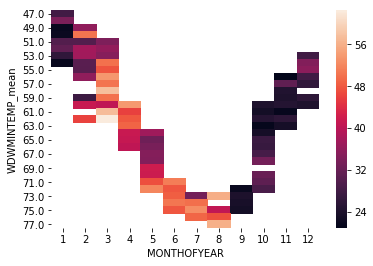

In [20]:
# Grouping by temperature and month

#aggregate by month
temp_splash2 = meta_splash2.groupby(['WDWMINTEMP_mean', 'MONTHOFYEAR'])['SPOSTMIN'].mean().reset_index()

temp_splash2 = temp_splash2.pivot("WDWMINTEMP_mean", "MONTHOFYEAR", "SPOSTMIN")
temp_splash2
ax = sns.heatmap(temp_splash2)

#### Park Hour vs Wait Time 

In [21]:
park_hour_df = meta_splash2[['SPOSTMIN','MKHOURS','MKOPEN','MKCLOSE','SEASON']]
#park_hour_df = park_hour_df[park_hour_df.MKHOURS != 14.91666667]
#park_hour_df = park_hour_df[park_hour_df.MKHOURS != 23.98333333]
park_hour_df.MKHOURS = park_hour_df.MKHOURS.round()
park_hour_df.MKHOURS.unique()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


array([16., 15., 14., 13., 11., 12., 17., 10., 18., 24.,  9.,  8.])

[Text(0, 0.5, 'Average Attendance by Minute'), Text(0.5, 0, 'Park Hour')]

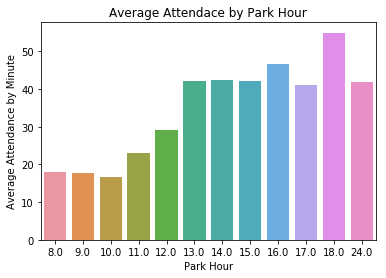

In [22]:
park_hour_df = meta_splash2[['SPOSTMIN','MKHOURS','MKOPEN','MKCLOSE','SEASON']]
#park_hour_df = park_hour_df[park_hour_df.MKHOURS != 14.91666667]
#park_hour_df = park_hour_df[park_hour_df.MKHOURS != 23.98333333]
park_hour_df.MKHOURS = park_hour_df.MKHOURS.round()
park_hour_df.MKHOURS.unique()

park_hour_df = park_hour_df.groupby("MKHOURS")["SPOSTMIN"].mean()
park_hour_df = park_hour_df.reset_index()
park_hour_df.head(n=3)
#park_hour_df = pd.DataFrame(avg_temp,columns=['MKHOURS','SPOSTMIN','SEASON'])


ax = sns.barplot(x = "MKHOURS", y = "SPOSTMIN", data = park_hour_df)
ax.set_title("Average Attendace by Park Hour")
ax.set(xlabel='Park Hour', ylabel='Average Attendance by Minute')

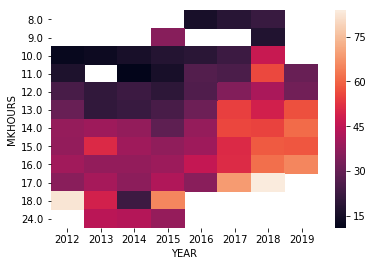

In [23]:
meta_splash3 = meta_splash2
meta_splash3.MKHOURS = meta_splash3.MKHOURS.round()
park_h_splash2 = meta_splash3.groupby(['MKHOURS', 'YEAR'])['SPOSTMIN'].mean().reset_index()

park_h_splash2 = park_h_splash2.pivot("MKHOURS", "YEAR", "SPOSTMIN")
ax = sns.heatmap(park_h_splash2)

#### Plotting Average Waittime by season

In [24]:
#Plotting by season
#First getting number of counts of observations per season:
print(meta_splash2.groupby('SEASON')['date'].count())

seasonal_splash = meta_splash2.groupby('SEASON')['SPOSTMIN'].mean().reset_index()
seasonal_splash

SEASON
CHRISTMAS                        108
CHRISTMAS PEAK                    43
COLUMBUS DAY                      24
EASTER                           152
FALL                             262
HALLOWEEN                         29
JERSEY WEEK                       60
JULY 4TH                          35
MARDI GRAS                        15
MARTIN LUTHER KING JUNIOR DAY     35
MEMORIAL DAY                      28
PRESIDENTS WEEK                   66
SEPTEMBER LOW                    174
SPRING                           689
SUMMER BREAK                     326
THANKSGIVING                      84
WINTER                           253
Name: date, dtype: int64


,SEASON,SPOSTMIN
0,CHRISTMAS,34.224714
1,CHRISTMAS PEAK,48.565998
2,COLUMBUS DAY,36.763775
3,EASTER,53.630275
4,FALL,24.844628
5,HALLOWEEN,22.765498
6,JERSEY WEEK,25.178213
7,JULY 4TH,51.264450
8,MARDI GRAS,44.311349
9,MARTIN LUTHER KING JUNIOR DAY,27.706818


(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text xticklabel objects>)

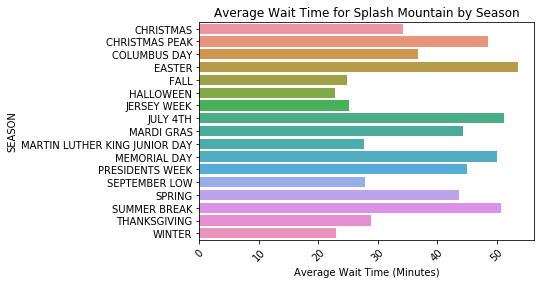

In [25]:
#Plot splash wait times by season:
ax = sns.barplot(x="SPOSTMIN", y = "SEASON", data = seasonal_splash)
ax.set(xlabel = 'Average Wait Time (Minutes)', ylabel = 'SEASON', title = 'Average Wait Time for Splash Mountain by Season')
plt.xticks(rotation = 45)

The most popular season for Splash Mountain was Easter, along with other hot seasons like July 4th and Summer Break. This is most likely because Splash Mountain is a water ride that is not as popular as the other rides during the more popular winter seasons like Christmas. Least popular seasons for Splash Mountain were therefore Halloween and September Low, which are consistent with Fall and Winter seasons.

Season durations:

Spring: 3/1-6/30 (not including Easter dates)

Easter: end of March to the middle of April

July 4th: 7/2-7/6 

Summer Break: 7/1-8/20 (not including July 4th dates)

September Low:  8/20-9/17

Halloween:  10/28-11/2


#### Average Wait Time Per Month for Splash Mountain Ride
We see that on average wait times are the longest during peak summer months of July, June

Text(0.5, 1.0, 'Splash Mountain Heatmap Month & Year')

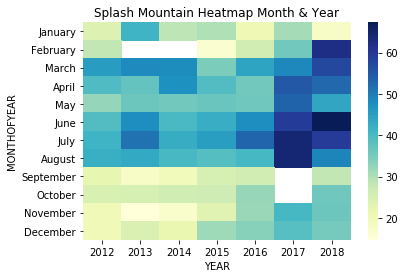

In [65]:
# Grouping by month and year

#aggregate by month
month_splash2 = meta_splash2.groupby(['MONTHOFYEAR', 'YEAR'])['SPOSTMIN'].mean().reset_index()
month_splash2 = month_splash2.pivot("MONTHOFYEAR", "YEAR", "SPOSTMIN").iloc[:,0:7] # Position based indexing
month_splash2 = month_splash2.rename(index= {1: "January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"} )

ax = sns.heatmap(month_splash2, cmap="YlGnBu")
ax.set_title('Splash Mountain Heatmap Month & Year')


We see that on average, wait times are the longest during the peak summer months of June and July, specifically during the latter years from 2016-1018. The white areas indicate when Magic Kingdom was shut down for refurbishments.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

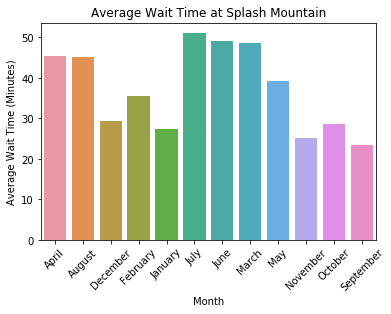

In [27]:
#aggregate by month
month_splash2 = meta_splash2.groupby(['MONTH'])['SPOSTMIN'].mean()
month_splash2 = month_splash2.reset_index()

ax = sns.barplot(x="MONTH", y = "SPOSTMIN", data = month_splash2)
ax.set(xlabel = 'Month', ylabel = 'Average Wait Time (Minutes)', title = 'Average Wait Time at Splash Mountain')
plt.xticks(rotation = 45)

In [28]:
month_splash2.loc[month_splash2['SPOSTMIN'].idxmax()] #Row with max index

MONTH          July
SPOSTMIN    51.0991
Name: 5, dtype: object

The month of July had the longest wait time of 50 minutes on average due to it being the peak season during summer.
Let's take a closer look of the Month of July!
#### Select July Only

count    217.000000
mean      51.099145
std       13.530316
min       19.500000
25%       41.250000
50%       50.450450
75%       60.630252
max       90.471698
Name: SPOSTMIN, dtype: float64


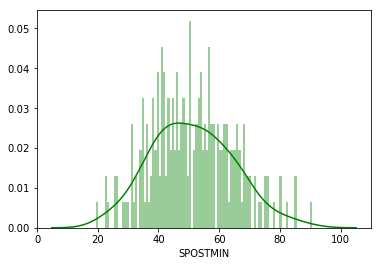

In [29]:
july = meta_splash2[meta_splash2['MONTH'] == "July"]
# Printing Wait Times

print(july['SPOSTMIN'].describe())
sns.distplot(july['SPOSTMIN'], color='g', bins=100, hist_kws={'alpha': 0.4});

The distribution plot above indicates a roughly normal distribution of wait times with a high percentage of wait times being around 40 minutes.

In [30]:
# How many Holidays in July?
july['HOLIDAYN'].drop_duplicates()

181      0
184    ind
Name: HOLIDAYN, dtype: object

Just one holiday in July, Independence Day. Lets look at hourly data on July 4th, Independence day!

In [31]:
# Longest Wait Time in July 4th of 2017
july.loc[july['SPOSTMIN'].idxmax(), 'SPOSTMIN']

90.47169811320755

In [32]:
## Finding Strongly Correlated Variables in July
july
july_corr = july.corr()['SPOSTMIN'][:-2] # -1 because the latest row is spostmin
golden_features_list = july_corr[abs(july_corr) > 0.2].sort_values(ascending=False)
print("There is {} strongly correlated values with SPOSTMIN:\n{}".format(len(golden_features_list), golden_features_list))

There is 34 strongly correlated values with SPOSTMIN:
SPOSTMIN               1.000000
AKHOURSEMHYEST         0.506234
HS20CAPACITY           0.504011
EP09CAPACITY           0.504011
AKHOURSEMH             0.502031
YEAR                   0.478169
AKHOURS                0.467447
AKHOURSYEST            0.461924
CapacityLost_HS        0.459778
CapacityLostWGT_HS     0.457239
AKHOURSTOM             0.441974
AKHOURSEMHTOM          0.441186
AKEMHEYEST             0.401357
AKEMHEVE               0.401357
AKEMHETOM              0.401357
CapacityLost_EP        0.398999
CapacityLostWGT_EP     0.394908
CapacityLostWGT_MK     0.350163
CapacityLost_MK        0.349012
MKDAYSSINCENONEVENT    0.299849
HSFIREWK               0.270728
CapacityLostWGT_AK     0.265131
CapacityLost_AK        0.263214
HOLIDAY                0.216078
EPHOURSEMHTOM          0.214244
MKPRDDAY               0.206385
MKHOURSEMHTOM         -0.206499
AKEMHMTOM             -0.206502
AKPRDDAY              -0.218396
HSEMHEYEST        

#### Average Wait Time Per Day From 2012-2019 For Splash Mountain

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

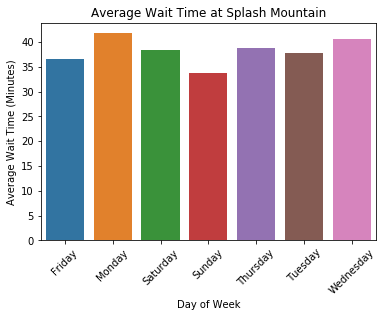

In [33]:
day_splash2 = meta_splash2.groupby('DAY')['SPOSTMIN'].mean()
day_splash2 = day_splash2.reset_index()

ax = sns.barplot(x="DAY", y = "SPOSTMIN", data = day_splash2)
ax.set(xlabel = 'Day of Week', ylabel = 'Average Wait Time (Minutes)', title = 'Average Wait Time at Splash Mountain')
plt.xticks(rotation = 45)

### Wait times in relation to other rides
#### Read in other rides wait time data and merge with meta:

In [34]:
#Merging each ride with meta_data, using date as key
#First need to change the date column to datetime so it can be merged with meta dataset.
pirates['date'] = pd.to_datetime(pirates['date'])
seven_dwarfs['date'] = pd.to_datetime(seven_dwarfs['date'])


In [35]:
meta_pirates = pd.merge(pirates, meta, left_on="date", right_on="DATE").drop('DATE', axis = 1)
meta_dwarfs = pd.merge(seven_dwarfs, meta, left_on="date", right_on="DATE").drop('DATE', axis = 1)

In [36]:
#Deleting irrelevant columns for faster processing
filter_col = [col for col in meta_pirates if col.startswith('AK') | col.startswith('HS') | col.startswith('EP')]
len(filter_col)
meta_pirates = meta_pirates.drop(filter_col,axis=1)

In [37]:
filter_col = [col for col in meta_dwarfs if col.startswith('AK') | col.startswith('HS') | col.startswith('EP')]
len(filter_col)
meta_dwarfs = meta_dwarfs.drop(filter_col,axis=1)

In [38]:
#Fill NA with 0
meta_pirates = meta_pirates.fillna(0)
meta_pirates.head()

,date,datetime,SPOSTMIN,SACTMIN,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,...,MKPRDDT2,MKPRDDN,MKPRDNGT,MKPRDNT1,MKPRDNT2,MKPRDNN,MKFIREWK,MKFIRET1,MKFIRET2,MKFIREN
0,2012-01-01,2012-01-01 10:14:00,5.0,0.0,0,1,0,1,1,2012,...,0,Celebrate A Dream Come True Parade,2,20:00,22:00,Main Street Electrical Parade,1,21:00,0,Wishes Nighttime Spectacular
1,2012-01-01,2012-01-01 12:13:00,5.0,0.0,0,1,0,1,1,2012,...,0,Celebrate A Dream Come True Parade,2,20:00,22:00,Main Street Electrical Parade,1,21:00,0,Wishes Nighttime Spectacular
2,2012-01-01,2012-01-01 13:50:00,10.0,0.0,0,1,0,1,1,2012,...,0,Celebrate A Dream Come True Parade,2,20:00,22:00,Main Street Electrical Parade,1,21:00,0,Wishes Nighttime Spectacular
3,2012-01-01,2012-01-01 14:42:00,10.0,0.0,0,1,0,1,1,2012,...,0,Celebrate A Dream Come True Parade,2,20:00,22:00,Main Street Electrical Parade,1,21:00,0,Wishes Nighttime Spectacular
4,2012-01-01,2012-01-01 20:40:00,5.0,0.0,0,1,0,1,1,2012,...,0,Celebrate A Dream Come True Parade,2,20:00,22:00,Main Street Electrical Parade,1,21:00,0,Wishes Nighttime Spectacular


In [39]:
#Need to separate into separate cells or kernal will die
meta_dwarfs = meta_dwarfs.fillna(0)
meta_dwarfs.head()

,date,datetime,SPOSTMIN,SACTMIN,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,...,MKPRDDT2,MKPRDDN,MKPRDNGT,MKPRDNT1,MKPRDNT2,MKPRDNN,MKFIREWK,MKFIRET1,MKFIRET2,MKFIREN
0,2013-06-04,2013-06-04 09:00:00,30.0,0.0,0,3,154,22,6,2013,...,0,Celebrate A Dream Come True Parade,2,21:00,23:00,Main Street Electrical Parade,1,22:00,0,Wishes Nighttime Spectacular
1,2013-06-04,2013-06-04 09:30:00,30.0,0.0,0,3,154,22,6,2013,...,0,Celebrate A Dream Come True Parade,2,21:00,23:00,Main Street Electrical Parade,1,22:00,0,Wishes Nighttime Spectacular
2,2013-06-04,2013-06-04 10:00:00,60.0,0.0,0,3,154,22,6,2013,...,0,Celebrate A Dream Come True Parade,2,21:00,23:00,Main Street Electrical Parade,1,22:00,0,Wishes Nighttime Spectacular
3,2013-06-04,2013-06-04 10:30:00,60.0,0.0,0,3,154,22,6,2013,...,0,Celebrate A Dream Come True Parade,2,21:00,23:00,Main Street Electrical Parade,1,22:00,0,Wishes Nighttime Spectacular
4,2013-06-04,2013-06-04 11:00:00,60.0,0.0,0,3,154,22,6,2013,...,0,Celebrate A Dream Come True Parade,2,21:00,23:00,Main Street Electrical Parade,1,22:00,0,Wishes Nighttime Spectacular


In [40]:
print(meta_pirates.shape, meta_dwarfs.shape)

(266897, 100) (226493, 100)


In [41]:
#Creating new datasets, only selecting specific columns, and adding a ride specification column
pirateswait = meta_pirates[['date','datetime','SPOSTMIN','SACTMIN','SEASON','YEAR']]
pirateswait['Ride'] = 'Pirates'
dwarfswait = meta_dwarfs[['date','datetime','SPOSTMIN','SACTMIN','SEASON','YEAR']]
dwarfswait['Ride'] = 'Seven Dwarfs'
splashwait = meta_splash[['date','datetime','SPOSTMIN','SACTMIN','SEASON','YEAR']]
splashwait['Ride'] = 'Splash Mountain'
splashwait.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,date,datetime,SPOSTMIN,SACTMIN,SEASON,YEAR,Ride
0,2012-01-01,2012-01-01 10:31:00,30.0,0.0,CHRISTMAS PEAK,2012,Splash Mountain
1,2012-01-01,2012-01-01 10:40:00,30.0,0.0,CHRISTMAS PEAK,2012,Splash Mountain
2,2012-01-01,2012-01-01 10:32:00,0.0,13.0,CHRISTMAS PEAK,2012,Splash Mountain
3,2012-01-01,2012-01-01 12:02:00,30.0,0.0,CHRISTMAS PEAK,2012,Splash Mountain
4,2012-01-01,2012-01-01 12:04:00,0.0,23.0,CHRISTMAS PEAK,2012,Splash Mountain


In [42]:
#Combine all three rides into one dataset to plot their wait times against each other
allrides = pd.concat([pirateswait, dwarfswait, splashwait])
allrides['datetime'] = pd.to_datetime(allrides['datetime'], infer_datetime_format=True)
allrides.shape

(745957, 7)

Pirates            157
Splash Mountain    125
Seven Dwarfs       123
Name: Ride, dtype: int64


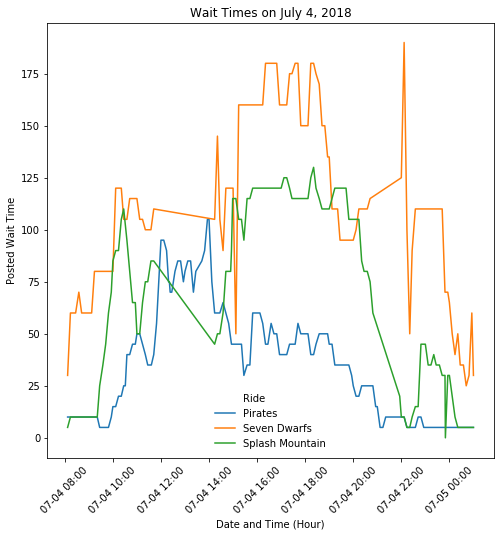

In [43]:
#Plot for July 4th of 2018
july = allrides.loc[(allrides.date == "2018-7-4")]

print(july['Ride'].value_counts())

plt.figure(figsize=(8,8))
ax = sns.lineplot(x="datetime", y="SPOSTMIN", hue = "Ride", data=july)
plt.xticks(rotation = 45)
ax.set(xlabel="Date and Time (Hour)", ylabel="Posted Wait Time")
ax.set(title="Wait Times on July 4, 2018")
myFmt = mdates.DateFormatter('%m-%d %H:%M')
ax.xaxis.set_major_formatter(myFmt)
ax.legend(loc='lower center', frameon=False)


The starting wait times for Splash Mountain and Pirates were much lower in the beginning of the day. The wait times for Seven Dwarfs were the most volatile compared to the other two rides, with large peaks and drops at 2pm and 10pm. Also, Pirates and Splash Mountain never had a posted wait time higher than Seven Dwarfs at any given time, with an exception at around 7pm, where wait times for Seven Dwarves dropped and wait times for Splash Mountain increased. Wait times for all rides seem to drop together at the same time periods, looking at the consistent steep drops in wait times for all rides at 8-10pm, due to parades and fireworks.


##### Now, looking at july 4th wait times for each year, to compare against each other.

In [44]:
#Getting only july fourth dates for all years for all rides
july4th = allrides.loc[(allrides.date.dt.day == 4) & (allrides.date.dt.month == 7)]
print(july4th.shape)
july4th.head(5)

(2308, 7)


,date,datetime,SPOSTMIN,SACTMIN,SEASON,YEAR,Ride
1480,2012-07-04,2012-07-04 11:51:00,20.0,0.0,JULY 4TH,2012,Pirates
1481,2012-07-04,2012-07-04 11:57:00,20.0,0.0,JULY 4TH,2012,Pirates
1482,2012-07-04,2012-07-04 12:26:00,40.0,0.0,JULY 4TH,2012,Pirates
1483,2012-07-04,2012-07-04 19:21:00,40.0,0.0,JULY 4TH,2012,Pirates
28845,2013-07-04,2013-07-04 08:14:00,5.0,0.0,JULY 4TH,2013,Pirates


In [45]:
july4th['YEAR'].value_counts()

2017    424
2014    422
2018    405
2016    405
2015    357
2013    283
2012     12
Name: YEAR, dtype: int64

Only 11 observations for 2012.

In [46]:
#Split by year
july2012, july2013, july2014, july2015, july2016, july2017, july2018 = [x for _, x in july4th.groupby('YEAR')]

Text(0.5, 1.0, 'Posted Wait Times on July 4, 2018')

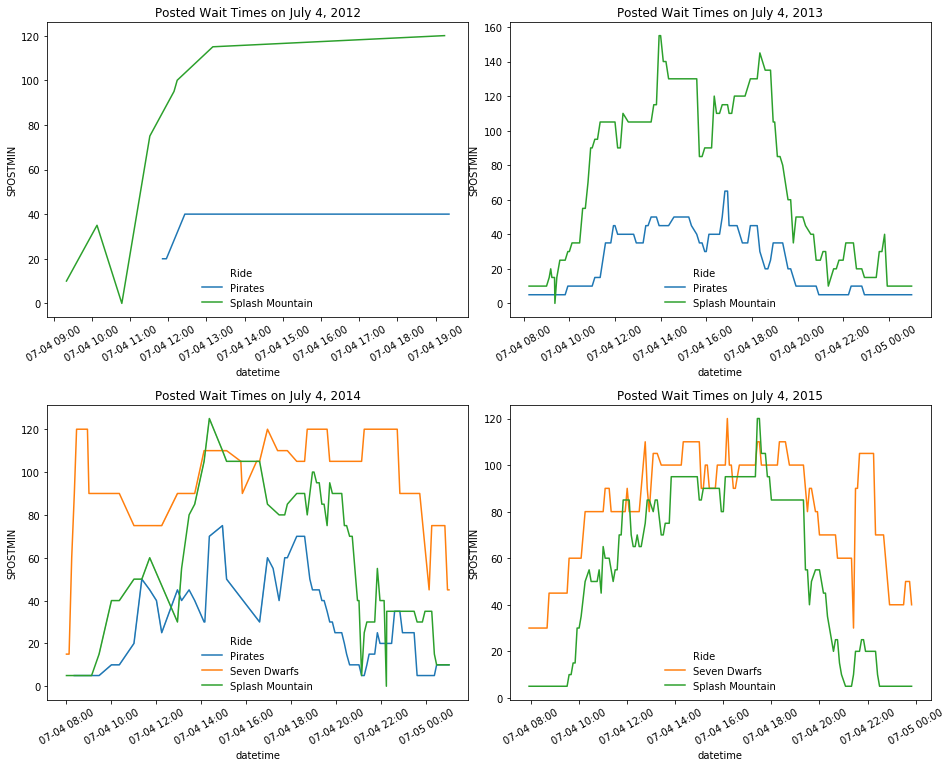

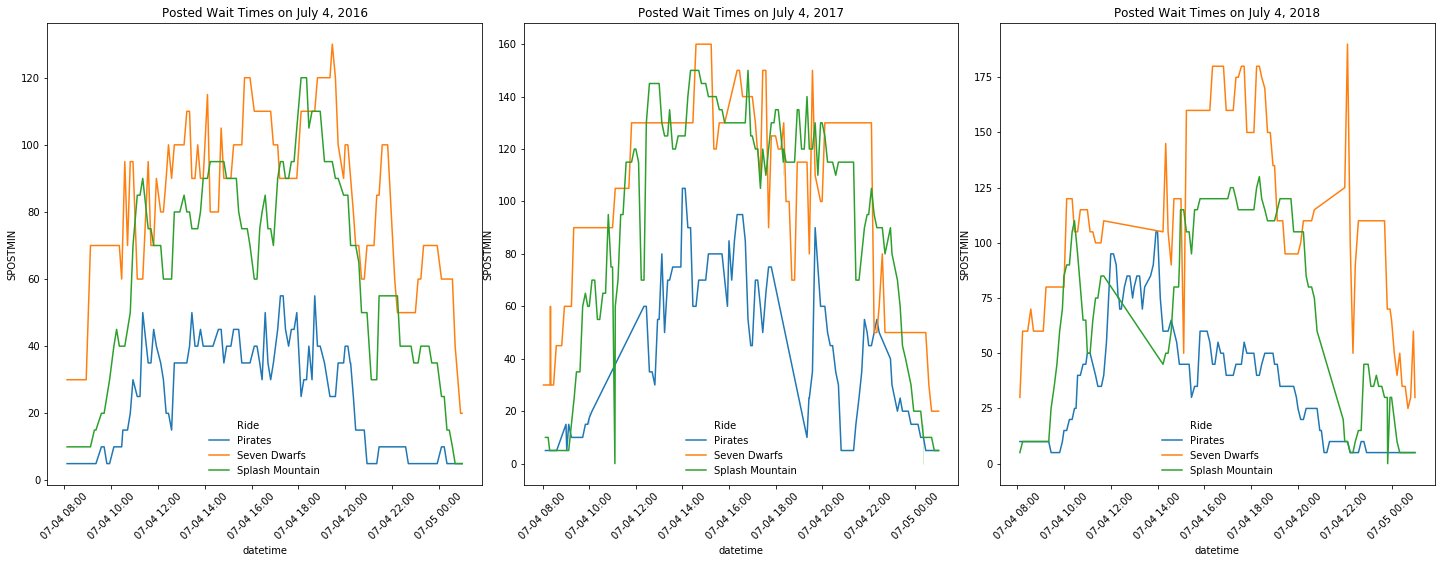

In [47]:
palette ={"Pirates":"C0","Seven Dwarfs":"C1","Splash Mountain":"C2"}

fig, ax = plt.subplots(2, 2, figsize=(13,10))
fig.tight_layout()
sns.lineplot(x="datetime", y="SPOSTMIN", hue = "Ride", palette = palette, data=july2012, ax = ax[0,0])
sns.lineplot(x="datetime", y="SPOSTMIN", hue = "Ride", palette = palette, data=july2013, ax = ax[0,1])
sns.lineplot(x="datetime", y="SPOSTMIN", hue = "Ride", palette = palette, data=july2014, ax = ax[1,0])
sns.lineplot(x="datetime", y="SPOSTMIN", hue = "Ride", palette = palette, data=july2015, ax = ax[1,1])
plt.subplots_adjust(hspace = 0.3)
fig.show()

for i in range(4):
    ax[i//2, i % 2].legend(loc='lower center', frameon=False)
    myFmt = mdates.DateFormatter('%m-%d %H:%M')
    ax[i//2, i % 2].xaxis.set_major_formatter(myFmt)
    for tick in ax[i//2, i % 2].get_xticklabels():
        tick.set_rotation(30)
        
ax[0,0].set_title('Posted Wait Times on July 4, 2012')
ax[0,1].set_title('Posted Wait Times on July 4, 2013')
ax[1,0].set_title('Posted Wait Times on July 4, 2014')
ax[1,1].set_title('Posted Wait Times on July 4, 2015')


#fig, ax = plt.subplots(1, 3, figsize=(13,7))
fig, ax = plt.subplots(1, 3, figsize=(20,7))
fig.tight_layout()
sns.lineplot(x="datetime", y="SPOSTMIN", hue = "Ride", palette = palette,  data=july2016, ax = ax[0])
sns.lineplot(x="datetime", y="SPOSTMIN", hue = "Ride", palette = palette, data=july2017, ax = ax[1])
sns.lineplot(x="datetime", y="SPOSTMIN", hue = "Ride", palette = palette, data=july2018, ax = ax[2])
for i in range(3):
    ax[i].legend(loc='lower center', frameon=False)
    myFmt = mdates.DateFormatter('%m-%d %H:%M')
    ax[i].xaxis.set_major_formatter(myFmt)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(45)

ax[0].set_title('Posted Wait Times on July 4, 2016')
ax[1].set_title('Posted Wait Times on July 4, 2017')
ax[2].set_title('Posted Wait Times on July 4, 2018')

Throughout the years, the same trend seems to be consistent on July 4th: Seven Dwarves have the longest wait times overall, starting with a higher wait time earlier on in the day than Splash Mountain and Pirates of the Carribean. There is more volatility among Seven Dwarves and also Splash Mountain in recent years compared to earlier years. We can see that the starting end times for Seven Dwarves is also considerably high, but these ending wait times have dropped in recent years. It also looks like Seven Dwarves and Splash Mountain fall and rise opposite to each other, especially in the past 3 years.

In [48]:
#Seeing the maximum posted wait time per ride per year
july2012max = july2012.groupby(['Ride'], as_index=False)['SPOSTMIN'].max()
july2013max = july2013.groupby(['Ride'], as_index=False)['SPOSTMIN'].max()
july2014max = july2014.groupby(['Ride'], as_index=False)['SPOSTMIN'].max()
july2015max = july2015.groupby(['Ride'], as_index=False)['SPOSTMIN'].max()
july2016max = july2016.groupby(['Ride'], as_index=False)['SPOSTMIN'].max()
july2017max = july2017.groupby(['Ride'], as_index=False)['SPOSTMIN'].max()
july2018max = july2018.groupby(['Ride'], as_index=False)['SPOSTMIN'].max()

dfs = [july2012max,july2013max,july2014max,july2015max,july2016max,july2017max,july2018max]
years = ['2012','2013','2014','2015','2016','2017','2018']
df_keys = pd.concat(dfs, keys= years)
df_keys

Ride  SPOSTMIN
2012 0          Pirates      40.0
     1  Splash Mountain     120.0
2013 0          Pirates      65.0
     1  Splash Mountain     155.0
2014 0          Pirates      75.0
     1     Seven Dwarfs     120.0
     2  Splash Mountain     125.0
2015 0     Seven Dwarfs     120.0
     1  Splash Mountain     120.0
2016 0          Pirates      55.0
     1     Seven Dwarfs     130.0
     2  Splash Mountain     120.0
2017 0          Pirates     105.0
     1     Seven Dwarfs     160.0
     2  Splash Mountain     150.0
2018 0          Pirates     105.0
     1     Seven Dwarfs     190.0
     2  Splash Mountain     130.0

Looking at the longest posted wait time per ride per year, we can see that for Splash Mountain the longest wait time has generally been around 125 minutes. Splash Mountain had the longest posted wiat time of 155 minutes in 2013.

### Time Series 
#### Plotting Average Wait Time per day by Year

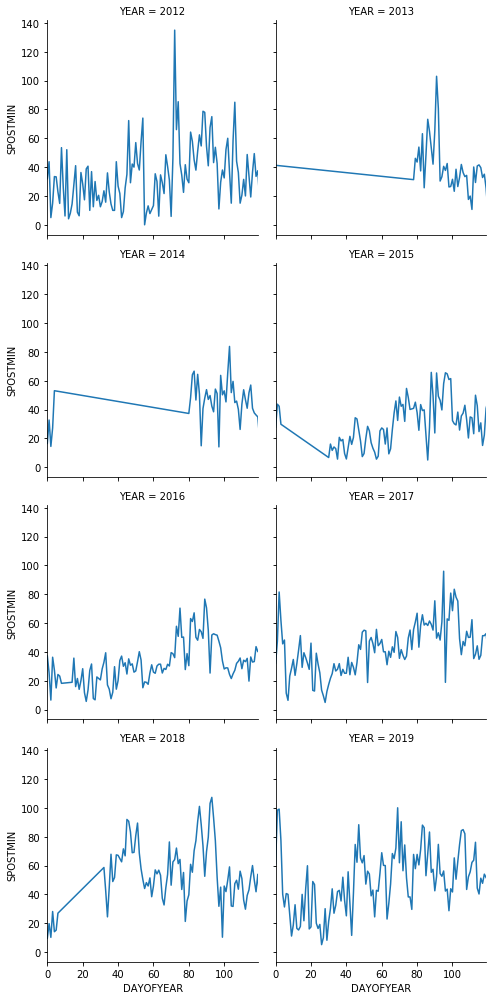

In [49]:
avg = meta_splash2
def dateplot(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)

ax = sns.FacetGrid(avg, col="YEAR",col_wrap=2, height=3.5)
ax = ax.map_dataframe(dateplot, "DAYOFYEAR", "SPOSTMIN")

In [50]:
print(avg.groupby('YEAR')['date'].count())

YEAR
2012    364
2013    288
2014    289
2015    339
2016    359
2017    284
2018    340
2019    120
Name: date, dtype: int64


# Conclusions:
It became apparent that due to the summer season being Disney World’s peak season, the average wait times per week, month, and year tended to be higher than Disney World’s low seasons during winter and fall. Wait times during each hour of the day varied by other factors such as parades or fireworks, but did not prove to have a large impact on the overall correlation of wait times for the ride Splash Mountain. This could be due to the gaps in our data in relation to posted wait times and the actual wait times. Dropping Disney World’s actual wait time data from our dataset during feature scaling due to lack thereof could prove to have influenced parade and fireworks times stronger than currently displayed in our analysis.
